In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from time import time
import pydaptivefiltering as pdf

In [2]:
# --- CONFIGURAÇÃO DA SIMULAÇÃO ---
np.random.seed(42)
n_samples = 2000

# 1. Definir o Sistema Desconhecido (Planta IIR)
# H(z) = (0.5 + 0.2z^-1) / (1 - 0.8z^-1 + 0.2z^-2)
b_true = np.array([0.5, 0.2])   # Numerador (Zeros)
a_true = np.array([0.8, -0.2])  # Denominador (Polos - sinal invertido conforme convenção do filtro)
# Nota: No ErrorEquation, o vetor w armazena [-a1, -a2, ..., b0, b1, ...]

zeros_order = len(b_true) - 1
poles_order = len(a_true)

# 2. Gerar Sinais
x = np.random.randn(n_samples) # Entrada: Ruído Branco
# Gerar saída da planta: d[k] = H(z)x[k] + ruído
d_clean = signal.lfilter(b_true, np.insert(-a_true, 0, 1.0), x)
d = d_clean + 0.01 * np.random.randn(n_samples) # Adiciona ruído de medição

In [3]:
# --- INICIALIZAÇÃO DO FILTRO ---
# Criar instância do ErrorEquation
# Parâmetros: zeros_order, poles_order, forgetting_factor (lambda), epsilon (reg.)
filt = pdf.ErrorEquation(
    zeros_order=zeros_order,
    poles_order=poles_order,
    forgetting_factor=0.99,
    epsilon=0.01
)

# --- EXECUÇÃO ---
result = filt.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[ErrorEquation] Completed in 58.00 ms


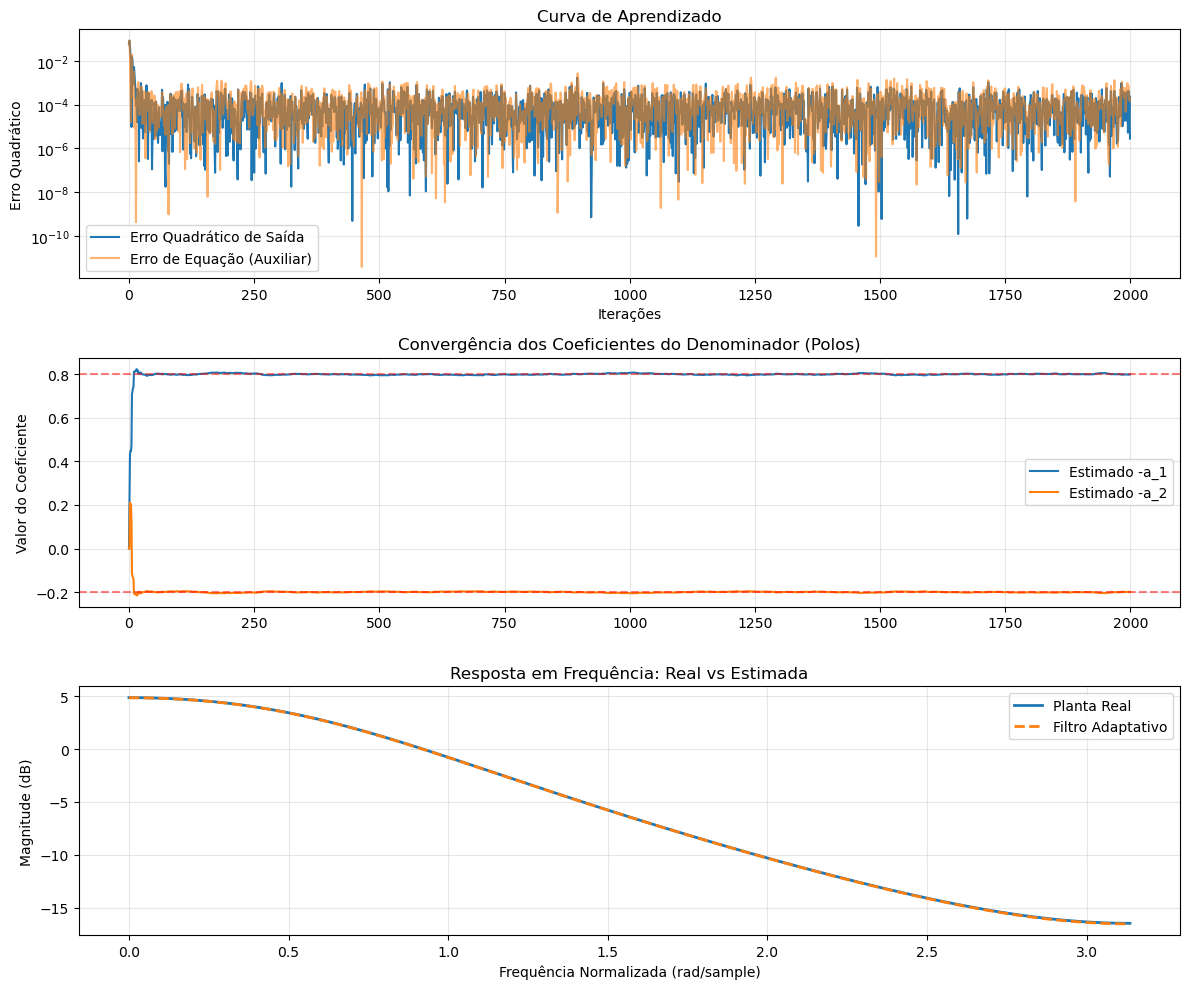

Coeficientes Reais (Polos -a): [ 0.8 -0.2]
Coeficientes Estimados (Polos): [ 0.7984955  -0.19890791]
Coeficientes Reais (Zeros b): [0.5 0.2]
Coeficientes Estimados (Zeros): [0.49882376 0.20104955]


In [4]:
# --- VISUALIZAÇÃO DOS RESULTADOS ---
plt.figure(figsize=(12, 10))

# 1. Erro de Aprendizado
plt.subplot(3, 1, 1)
plt.semilogy(result.errors**2, label='Erro Quadrático de Saída')
plt.semilogy(result.extra["auxiliary_errors"]**2, label='Erro de Equação (Auxiliar)', alpha=0.6)
plt.title('Curva de Aprendizado')
plt.xlabel('Iterações')
plt.ylabel('Erro Quadrático')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Trajetória dos Coeficientes dos Polos (Denominador)
plt.subplot(3, 1, 2)
a_coeffs = result.extra["a_coefficients"]
for i in range(poles_order):
    plt.plot(a_coeffs[:, i], label=f'Estimado -a_{i+1}')
    plt.axhline(y=a_true[i], color='r', linestyle='--', alpha=0.5)
plt.title('Convergência dos Coeficientes do Denominador (Polos)')
plt.ylabel('Valor do Coeficiente')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Resposta em Frequência Final
plt.subplot(3, 1, 3)
w_final = filt.w
# Separar coeficientes b e a do vetor w
a_est = w_final[:poles_order]
b_est = w_final[poles_order:]

w_freq, h_true = signal.freqz(b_true, np.insert(-a_true, 0, 1.0))
_, h_est = signal.freqz(b_est, np.insert(-a_est, 0, 1.0))

plt.plot(w_freq, 20 * np.log10(np.abs(h_true)), label='Planta Real', linewidth=2)
plt.plot(w_freq, 20 * np.log10(np.abs(h_est)), '--', label='Filtro Adaptativo', linewidth=2)
plt.title('Resposta em Frequência: Real vs Estimada')
plt.xlabel('Frequência Normalizada (rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Coeficientes Reais (Polos -a): {a_true}")
print(f"Coeficientes Estimados (Polos): {a_est}")
print(f"Coeficientes Reais (Zeros b): {b_true}")
print(f"Coeficientes Estimados (Zeros): {b_est}")